In [139]:
import pandas as pd
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
df = pd.read_csv("/Users/ayumuueda/Desktop/UC-Transfer-Analyzer/data/berkeley_table2.csv")

In [141]:
def first_q(col):
    return float(col[0:4])

def third_q(col):
    return float(col[7:])

In [142]:
def preprocess(df):
    
    dump_list = []

    for i, k in dict(df["Major name"].value_counts()).items():
        if k == 1 :
            dump_list.append(i)

    df = df[~df["Major name"].isin(dump_list)]
    df = df[df["Admit GPA range"] != "masked"]
    df = df[df["Enroll GPA range"] != "masked"]
    df = df.sort_values(by=["Major name", "year"])
    df["lag"] = df.groupby(["Major name"])["Admit rate"].shift(-1).fillna(0)
    df["25th admit"] = df["Admit GPA range"].apply(first_q)
    df["25th enroll"] = df["Enroll GPA range"].apply(first_q)
    df["75th admit"] = df["Admit GPA range"].apply(third_q)
    df["75th enroll"] = df["Enroll GPA range"].apply(third_q)
    df["approx median admit"] = (df["25th admit"] + df["75th admit"]) / 2
    df["approx median Enroll"] = (df["25th enroll"] + df["75th enroll"]) / 2

    df = df.drop(["25th admit","25th enroll", "75th admit", "75th enroll", "approx median admit", "Enrolls"], axis=1)
    df = df.drop(["Admit GPA range","Enroll GPA range"], axis = 1)
    return df


In [143]:
df = preprocess(df)

In [144]:
df["max_year"] = df.groupby("Major name")['year'].transform(max)

In [145]:
df

,Major name,Admit rate,Yield rate,Admits,Applicants,year,lag,approx median Enroll,max_year
236,African-american studies (l&S),0.161290,1.000000,5,31,2016,0.230769,3.575,2022
426,African-american studies (l&S),0.230769,0.555556,9,39,2019,0.303030,3.690,2022
636,African-american studies (l&S),0.303030,0.700000,10,33,2022,0.000000,3.360,2022
6,American studies (l&S),0.452381,0.789474,19,42,2012,0.416667,3.370,2022
63,American studies (l&S),0.416667,0.700000,10,24,2013,0.473684,3.375,2022
...,...,...,...,...,...,...,...,...,...
284,Urban studies (coed),0.125000,1.000000,5,40,2016,0.282051,3.355,2022
348,Urban studies (coed),0.282051,0.727273,11,39,2017,0.205882,3.460,2022
412,Urban studies (coed),0.205882,0.714286,7,34,2018,0.225806,3.380,2022
620,Urban studies (coed),0.225806,0.857143,7,31,2021,0.261905,3.735,2022


In [146]:
test = df[df['max_year'] == df['year']]
train = df[df['max_year'] != df['year']]
actual = test['Admit rate']
train_y = train['lag']
test_x = test.drop(["Major name", "max_year","year", "lag"], axis=1)
train_x = train.drop(["Major name", "max_year", "year", "lag"], axis=1)

metric is RMSE, MAE, MSE 

In [147]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(train_x, train_y)
predicted_random = regr.predict(test_x)

In [148]:
clf = Ridge(alpha=1.0)
clf.fit(train_x, train_y)
predicted_ridge = clf.predict(test_x)

In [149]:
test['predicted_ridge'] = predicted_ridge
test['predicted_random'] = predicted_random
test['this_year'] = actual

/var/folders/h0/sl38029x0_j4khlt53w1_8y00000gn/T/ipykernel_69370/2758274165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_ridge'] = predicted_ridge
/var/folders/h0/sl38029x0_j4khlt53w1_8y00000gn/T/ipykernel_69370/2758274165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_random'] = predicted_random
/var/folders/h0/sl38029x0_j4khlt53w1_8y00000gn/T/ipykernel_69370/2758274165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [150]:
test

,Major name,Admit rate,Yield rate,Admits,Applicants,year,lag,approx median Enroll,max_year,predicted_ridge,predicted_random,this_year
636,African-american studies (l&S),0.303030,0.700000,10,33,2022,0.0,3.360,2022,0.344271,0.291958,0.303030
637,American studies (l&S),0.739130,0.823529,17,23,2022,0.0,3.405,2022,0.615114,0.472201,0.739130
695,Anthropology (l&S),0.437288,0.457364,129,295,2022,0.0,3.710,2022,0.410748,0.453529,0.437288
681,Applied mathematics (l&S),0.508333,0.715847,183,360,2022,0.0,3.865,2022,0.445923,0.468728,0.508333
635,Architecture (coed),0.198381,0.816327,49,247,2022,0.0,3.820,2022,0.228151,0.246615,0.198381
658,Art (l&S),0.248804,0.500000,52,209,2022,0.0,3.850,2022,0.265726,0.269224,0.248804
687,Astrophysics (l&S),0.641509,0.676471,34,53,2022,0.0,3.545,2022,0.545210,0.468728,0.641509
652,Bioengineering (coe),0.203125,0.500000,26,128,2022,0.0,3.770,2022,0.243870,0.248964,0.203125
647,Business administration (ugba),0.045792,0.909910,111,2424,2022,0.0,3.925,2022,-0.027935,0.134365,0.045792
684,Chemical biology (coc),0.184358,0.242424,33,179,2022,0.0,3.815,2022,0.229896,0.211746,0.184358


/var/folders/h0/sl38029x0_j4khlt53w1_8y00000gn/T/ipykernel_69370/1534458401.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

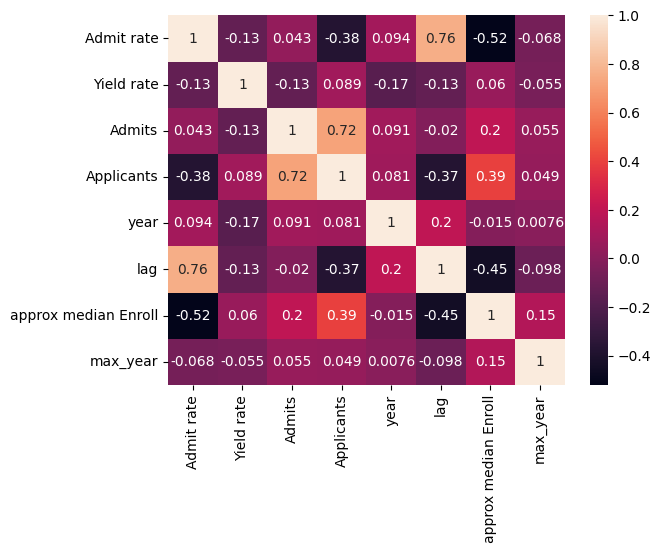

In [151]:
sns.heatmap(train.corr(), annot=True)